<a href="https://www.kaggle.com/code/ahmedhassounaa/teeth-classification-project?scriptVersionId=193482678" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/ahmedhassounaa/teeth-classification-project?scriptVersionId=193482678" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Data Acquisition and Setup

In this section, we begin by downloading the dataset, setting up the environment, and preparing the data for further processing.

### 1. Downloading the Dataset
The dataset is downloaded from a shared Google Drive link using the `gdown` library. This dataset contains images of various types of teeth, which will be used for training and testing the classification model.


In [109]:
!pip install gdown
import gdown
!gdown --id 1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY


/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY
From (redirected): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY&confirm=t&uuid=7f146474-c420-4113-a933-08b5f5e29144
To: /kaggle/working/Teeth DataSet.zip
100%|███████████████████████████████████████| 49.1M/49.1M [00:00<00:00, 169MB/s]



## Project Setup: Data Preparation

First, the dataset is downloaded from Google Drive using the `gdown` tool. After the download is complete, several essential libraries are imported, including PyTorch, torchvision, and PIL, which are necessary for handling images and performing transformations. The dataset, provided in a `.zip` file, is then extracted into the working directory using Python's `zipfile` module.



In [110]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import os
from PIL import Image
import matplotlib.pyplot as plt
import zipfile
with zipfile.ZipFile('/kaggle/working/Teeth DataSet.zip', 'r') as zip_ref:
    zip_ref.extractall()

!rm -rf /kaggle/working/Teeth_Dataset/Testing/outputs
!rm -rf /kaggle/working/Teeth_Dataset/Testing/output
!rm -rf /kaggle/working/Teeth_Dataset/Testing/out
!rm -rf /kaggle/working/Teeth_Dataset/Testing/output_image.jpg
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Custom Dataset Class: `TeethDataset`

The `TeethDataset` class is a custom PyTorch dataset designed to load and preprocess teeth images stored in a directory structure where subdirectories represent class labels.

- **Initialization (`__init__`)**: 
  - Takes a directory path and an optional transformation function.
  - Maps each label (subdirectory) to an integer and stores image paths and their corresponding labels.

- **Length (`__len__`)**: 
  - Returns the total number of images in the dataset.

- **Get Item (`__getitem__`)**: 
  - Retrieves an image and its label by index.
  - Applies transformations if provided.


In [111]:
from torchvision import transforms
import os
from PIL import Image
from torch.utils.data import Dataset

class TeethDataset(Dataset):
    def __init__(self, directory, transform=None):
        """
        Args:
            directory (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.directory = directory
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_dict = {}  # Dictionary to map labels to indices
        current_label_index = 0

        for label in sorted(os.listdir(directory)):
            label_path = os.path.join(directory, label)
            if os.path.isdir(label_path):  # Make sure it's a directory
                if label not in self.label_dict:
                    self.label_dict[label] = current_label_index
                    current_label_index += 1
                
                for img in sorted(os.listdir(label_path)):
                    self.images.append(os.path.join(label_path, img))
                    self.labels.append(self.label_dict[label])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]  # Directly use the mapped integer label

        if self.transform:
            image = self.transform(image)

        return image, label


## Image Transformations

A series of image transformations are applied to prepare the teeth images for training. These transformations are composed using `transforms.Compose` and include:

- **Resize**: Resizes images to a fixed size of 150x150 pixels.  
  *Reason*: Ensures a consistent input size for the neural network, which is necessary for batch processing and compatible with pre-trained models.

- **Random Horizontal Flip**: Randomly flips images horizontally.  
  *Reason*: Augments the dataset by creating mirror images, which helps the model generalize better by learning invariant features, reducing overfitting.

- **ToTensor**: Converts the image to a PyTorch tensor and scales pixel values to the range [0, 1].  
  *Reason*: Converts images into a format suitable for PyTorch, allowing for efficient processing and enabling the use of GPU acceleration.

- **Normalize**: Normalizes the image tensor using the specified mean and standard deviation.  
  *Reason*: Standardizes the input distribution, which accelerates convergence during training and is necessary when using pre-trained models that expect images normalized in this manner.


In [112]:
transformations  = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Data Loading

After defining the dataset and transformations, we load the training and validation data using the `DataLoader` class from PyTorch. This allows for efficient data loading and batching during model training and validation.

- **Training Dataset and DataLoader**:
  - `train_dataset`: Created using the `TeethDataset` class, pointing to the directory containing the training images. The transformations defined earlier are applied to each image.
  - `train_loader`: Utilizes the `DataLoader` class to load data from `train_dataset` in batches of 64 images. The `shuffle=True` parameter ensures that the data is shuffled at the beginning of each epoch, which helps in reducing model overfitting by providing varied data batches.

- **Validation Dataset and DataLoader**:
  - `validation_dataset`: Similarly, the validation dataset is created using the `TeethDataset` class, pointing to the directory containing validation images. The same transformations are applied to ensure consistency between training and validation data.
  - `validation_loader`: Loads data from `validation_dataset` in batches of 64 images. Here, `shuffle=False` ensures that the validation data is processed in a consistent order, which is crucial for accurate model evaluation.


In [113]:
train_dataset = TeethDataset('/kaggle/working/Teeth_Dataset/Training', transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

validation_dataset = TeethDataset('/kaggle/working/Teeth_Dataset/Validation', transform=transformations)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=2)

testing_dataset = TeethDataset('/kaggle/working/Teeth_Dataset/Testing', transform=transformations)
testing_loader = DataLoader(testing_dataset, batch_size=64, shuffle=False, num_workers=2)

## Inspecting a Batch of Training Data

This step involves checking the integrity of the data loading and transformation process by extracting and visualizing a batch of images and their corresponding labels:

- **Batch Extraction**: 
  - A single batch of images (`train_features`) and labels (`train_labels`) is retrieved from the `train_loader` using `next(iter(train_loader))`.
  - This allows us to inspect a portion of the dataset as it would be fed into the model.

- **Batch Shape Verification**:
  - The shapes of the feature and label batches are printed to ensure that the data is correctly batched. This verifies that the data is in the expected format and ready for training.

- **Image Selection and Adjustment**:
  - One image from the batch is selected (`train_features[5]`) for visualization.
  - The image tensor is permuted to change the dimensions from `[C, H, W]` (Channel, Height, Width) to `[H, W, C]` for compatibility with `matplotlib`.

- **Normalization and Visualization**:
  - The image is normalized to the [0, 1] range for display purposes.
  - The selected image is then displayed using `plt.imshow()`, and the associated label is printed to confirm the class.


Feature batch shape: torch.Size([64, 3, 150, 150])
Labels batch shape: torch.Size([64])


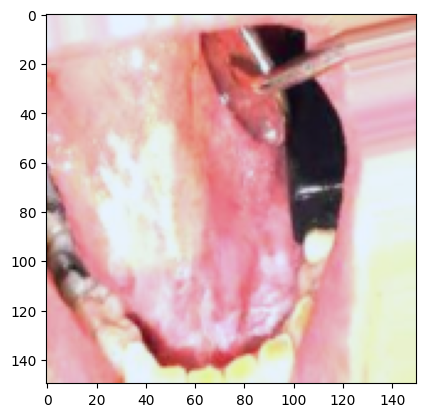

Label: 3


In [114]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Get the first image from the batch and adjust its dimensions
img = train_features[0].permute(1, 2, 0)

# Normalize the pixel values to [0, 1] for displaying
img = img - img.min()
img = img / img.max()

label = train_labels[0]

# Display the image
plt.imshow(img)
plt.show()
print(f"Label: {label}")

### Model Definition: TeethNet

The `TeethNet` class defines a straightforward convolutional neural network (CNN) optimized for classifying images of teeth. This network architecture is designed to be effective yet relatively simple, making it suitable for fundamental image classification tasks:

#### Convolutional Layers:
- **`conv1`**: Applies a convolution with 32 filters of size 3x3, using padding of 1 to preserve spatial dimensions.
- **`conv2`**: Increases the depth with 64 filters of the same size (3x3), continuing the pattern of preserving spatial dimensions.
- **`conv3`**: Further increases the filter depth to 128, maintaining a 3x3 kernel size.

Each of these layers is followed by a ReLU activation function and a max pooling operation, which reduces the spatial dimensions by half, thus progressively condensing the feature maps.

#### Pooling:
- **`pool`**: Utilizes max pooling with a 2x2 window to reduce spatial dimensions following each convolutional layer. This is integrated into the sequence of operations after each ReLU activation within the forward pass.

#### Activation Function:
- **`ReLU`**: The ReLU activation function is used to introduce non-linearity after each convolutional layer, facilitating the learning of complex patterns in the images.

#### Fully Connected Layers:
- **`fc1`**: A linear layer that connects the flattened output from the final pooled feature map to a 512-dimensional hidden layer. This transition begins the process of culminating the learned features into predictions.
- **`fc2`**: This layer further processes the features, reducing them down to 7 output classes corresponding to the types of teeth.

#### Forward Pass:
- The `forward` method defines the data flow through the network: sequential application of convolutions, followed by ReLU activation and pooling. The resulting feature maps are then flattened and passed through two fully connected layers. The ReLU activation function is also applied after the first fully connected layer to maintain non-linearity.

This architecture ensures a balance between model complexity and computational efficiency, making it well-suited for practical applications in dental image classification.



In [115]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class TeethNet(nn.Module):
    def __init__(self):
        super(TeethNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 7)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
            
        x = x.view(-1, 128 * 18 * 18)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = TeethNet()
model.to(device)

TeethNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=41472, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

## Training the Model

The following code sets up and trains the `TeethNet` model using stochastic gradient descent (SGD) and cross-entropy loss.

- **Loss Function**:
  - `criterion`: Uses `nn.CrossEntropyLoss()` to compute the loss between the model's predictions and the true labels. This is suitable for classification tasks.

- **Optimizer**:
  - `optimizer`: An instance of `optim.SGD` is used to update the model's parameters. It includes:
    - **Learning Rate** (`lr`): Set to 0.01.
    - **Momentum**: Set to 0.9, which helps accelerate convergence and smoothens updates.

- **Training Process**:
  - **Number of Epochs**: The model is trained for 10 epochs.
  - **Epoch Loop**: Iterates over the dataset multiple times.
  - **Mini-batch Loop**: For each mini-batch in the training data:
    - **Data Unpacking**: Extracts inputs and labels.
    - **Gradient Zeroing**: Resets the gradients of model parameters.
    - **Forward Pass**: Computes the model's predictions.
    - **Loss Calculation**: Evaluates the loss using the criterion.
    - **Backward Pass**: Computes gradients with respect to the loss.
    - **Parameter Update**: Updates model parameters using the optimizer.
    - **Loss Tracking**: Accumulates and prints the average loss every 100 mini-batches.


## Model Evaluation and Saving

The code evaluates the trained model on the validation dataset to assess its performance. Using `torch.no_grad()`, it disables gradient calculations for efficiency. For each batch in the validation set, the model makes predictions, which are compared to the true labels to count correct predictions. The accuracy is then calculated and printed as a percentage.

After evaluating the model, its parameters are saved to a file (`TeethModel.pth`) using `torch.save()`, allowing for future use or deployment.

In [116]:
import torch
import matplotlib.pyplot as plt



model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 50

# Lists to track loss and accuracy
train_losses, val_losses, train_accuracy, val_accuracy = [], [], [], []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct, total = 0, 0
    
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)

    # Validation phase
    model.eval()  # Set model to evaluate mode
    val_running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for data in validation_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_running_loss / len(validation_loader))
    val_accuracy.append(100 * correct / total)

    print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy[-1]:.2f}%')

# Save the model after training
torch.save(model.state_dict(), '/kaggle/working/TeethModel.pth')


Epoch 1: Train Loss: 1.8417, Train Acc: 23.58%, Val Loss: 1.7382, Val Acc: 30.16%
Epoch 2: Train Loss: 1.6803, Train Acc: 35.83%, Val Loss: 1.7353, Val Acc: 31.52%
Epoch 3: Train Loss: 1.5601, Train Acc: 40.36%, Val Loss: 1.4586, Val Acc: 43.09%
Epoch 4: Train Loss: 1.3708, Train Acc: 47.91%, Val Loss: 1.3944, Val Acc: 45.91%
Epoch 5: Train Loss: 1.2087, Train Acc: 54.94%, Val Loss: 1.2467, Val Acc: 53.40%
Epoch 6: Train Loss: 0.9331, Train Acc: 65.99%, Val Loss: 1.0437, Val Acc: 60.89%
Epoch 7: Train Loss: 0.7385, Train Acc: 73.15%, Val Loss: 1.0062, Val Acc: 62.65%
Epoch 8: Train Loss: 0.5807, Train Acc: 79.75%, Val Loss: 0.7312, Val Acc: 72.18%
Epoch 9: Train Loss: 0.4016, Train Acc: 86.36%, Val Loss: 0.6457, Val Acc: 74.51%
Epoch 10: Train Loss: 0.3126, Train Acc: 89.12%, Val Loss: 0.6655, Val Acc: 75.39%
Epoch 11: Train Loss: 0.2578, Train Acc: 90.96%, Val Loss: 0.7745, Val Acc: 75.58%
Epoch 12: Train Loss: 0.1573, Train Acc: 94.88%, Val Loss: 0.5520, Val Acc: 80.64%
Epoch 13: Tra

### Visualization of Training Progress

This section of the code is dedicated to visualizing the training and validation performance of our model across epochs. We create two plots side by side for easy comparison: one for loss and the other for accuracy.

#### Loss vs. Epoch
- **Purpose**: To track how the loss changes as training progresses for both the training set and the validation set. This helps in understanding if the model is learning effectively and converging towards a minimum.

#### Accuracy vs. Epoch
- **Purpose**: To monitor the accuracy of the model on the training and validation datasets. This indicates how well the model is generalizing beyond the data it has seen during training.


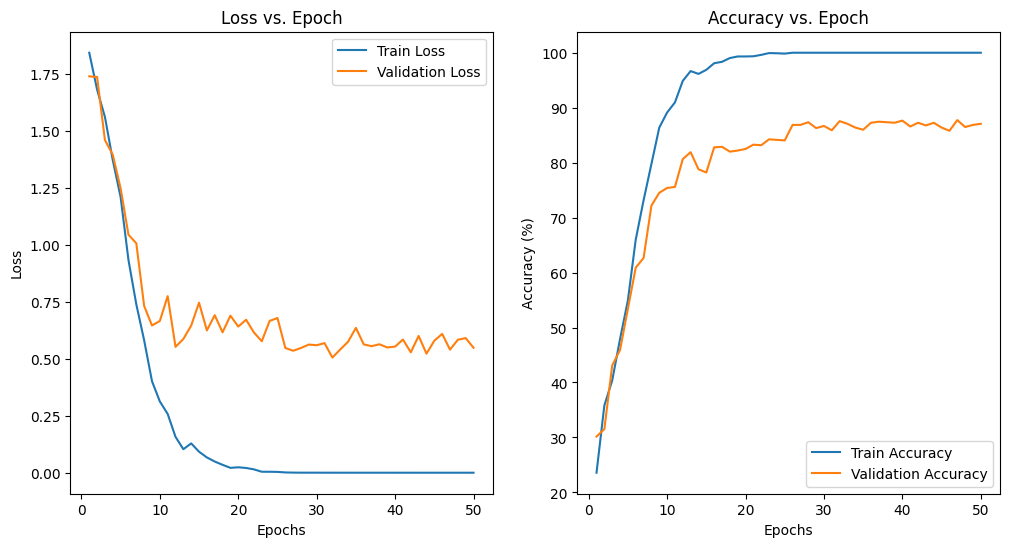

In [117]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


## Purpose of the Model Testing Function

This function evaluates a trained neural network on test data to determine its accuracy, providing essential insights into its real-world performance. Additionally, it saves the model's trained parameters, facilitating future use and development without retraining, ensuring efficiency and continuity in deploying the model. This step is crucial for confirming the model's effectiveness and readiness for practical applications.

In [122]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for data in testing_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the testing images: %d %%' % (100 * correct / total))

# Save the model
torch.save(model.state_dict(), '/kaggle/working/TeethModel.pth')



Accuracy of the network on the testing images: 88 %
